<a href="https://colab.research.google.com/github/nebulous05/influence-functions-pytorch/blob/main/fig2_middle_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### PROCEDURE ###

# Step 1: Train a model on the 10-class MNIST dataset
# Step 2: Arbitrarily select a wrongly-classified test point, z_test
# Step 3: Compute the influence I_up,loss(z, z_test) for every training point z
# Step 4: Select the 500 training points with the largest |I_up,loss(z, z_test)|
# Step 5: Compute the actual change in test loss after removing the point and
#         retraining for each of the 500 points
# Step 6: Plot -1/n (I_up,loss(z, z_test)) vs. actual change in test loss for
#         each of the 500 points

In [2]:
# Step 1: Train a model on the 10-class MNIST dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.autograd import grad
from torch.utils.data import Subset

In [4]:
# load train data: 60,000 samples
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# split train dataset into train and validation
train_size = 55000
val_size = 5000
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# load test data: 10,000 samples
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 59190595.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2151267.01it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13828934.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3660747.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# create data loaders with batch size 1400
train_loader = DataLoader(dataset=train_data, batch_size=1400, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=1400, shuffle=False)

In [6]:
# some functions to retrieve/view data
def get_item(index, dataset='train'):
    ''' returns a pair (image_tensor, label_int) '''
    if dataset == 'train':
        return train_data[index]
    elif dataset == 'test':
        return test_data[index]
    elif dataset == 'val':
        return val_data[index]

def show_image(index, dataset='train'):
    ''' show an image with matplotlib '''
    if dataset == 'train':
        img = train_data[index][0].numpy().reshape(28, 28)
    elif dataset == 'test':
        img = test_data[index][0].numpy().reshape(28, 28)
    elif dataset == 'val':
        img = val_data[index][0].numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [7]:
# custom module for logistic regression
class LRModel(nn.Module):
    def __init__(self):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.linear(x)

In [8]:
# instantiate the model
model = LRModel()

# save the model
torch.save(model.state_dict(), 'initial_model_weights.pth')

In [9]:
# define model training function
def train_model(model, train_loader, val_loader, epochs=3, lr=0.001):
    # set random seeds to avoid stochasicity
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    optimizer = optim.LBFGS(model.parameters(), lr=lr) # use LBFGS optimizer
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            def closure():
              optimizer.zero_grad()
              outputs = model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              return loss

            loss = optimizer.step(closure)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

        # Validation Step
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy: {100 * correct / total}%')

In [10]:
# fit the model to the train data
train_model(model, train_loader, val_loader)

Epoch 1, Loss: 1.3658491536974906
Validation Accuracy: 89.56%
Epoch 2, Loss: 0.6465988501906395
Validation Accuracy: 91.06%
Epoch 3, Loss: 0.4210507899522781
Validation Accuracy: 91.7%


tensor([[ 1.0265, -1.6564, -0.0584, -0.9634,  2.1960,  4.6798,  0.4425, -1.0354,
         -0.2503, -2.1560]], grad_fn=<AddmmBackward0>)
label:  5


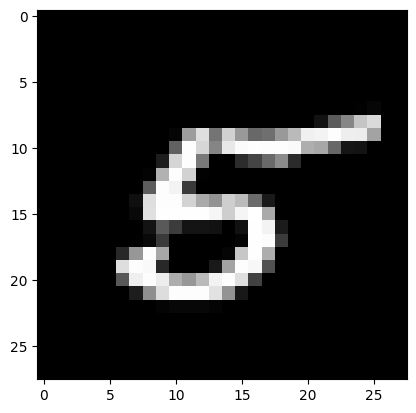

In [11]:
# check on example
image_example = get_item(5)

outputs = model(image_example[0])
print(outputs)
print("label: ", image_example[1])

show_image(5)

In [12]:
# find all misclassified test points
def find_misclassified_indices(model, test_data=test_data):
  ''' returns a list of indices of all incorrectly labeled test points '''
  model.eval()
  indices = []
  for i in range(len(test_data)):
    image, label = get_item(i, dataset='test')
    with torch.no_grad():
      outputs = model(image)
      _, predicted = torch.max(outputs, 1)
      if predicted != label:
        indices.append(i)
  return indices

mislabeled_indices = find_misclassified_indices(model)
print("Number of misidentified testing points: ", len(mislabeled_indices))
print("Misidentified index: ", random.choice(mislabeled_indices))

Number of misidentified testing points:  824
Misidentified index:  6981


label:  5
prediction:  tensor([6])


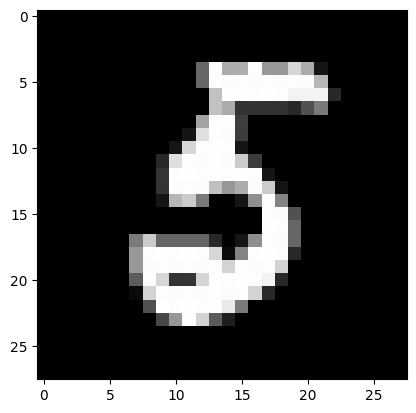

In [13]:
# show the misidentified point
bad_index = 6981

image, label = get_item(bad_index, dataset='test')
print("label: ", label)
output = model(image)
_, predicted = torch.max(output, 1)
print("prediction: ", predicted)

show_image(bad_index, dataset='test')

In [14]:
# Step 3: Compute the influence I_up,loss(z, z_test) for every training point z

In [40]:
# get gradient of loss wrt params to kick off LiSSA
def compute_v(model, z_test, z_test_label):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    model.zero_grad()
    output = model(z_test)
    z_test_label = torch.tensor([z_test_label], dtype=torch.long)
    loss = loss_fn(output, z_test_label)

    v = grad(loss, model.parameters())
    return v

# returns list of torch tensors containing product of Hessian and v.
def hvp(y, w, v):
    # First backprop: Compute the gradient of y with respect to w
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(first_grads, v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop: Compute gradient of elementwise product with respect to w
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

# Precompute s_test using stochastic estimation, now using a mini-batch from the training data
def compute_s_test(model, z_test, v, scale=25, recursion_depth=5000, damping=0.07, batch_size=1, num_samples=10):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    s_test = None

    for j in range(num_samples):
        print("Beginning of repeat #", j+1)
        h_estimate = v  # Start with the gradient of z_test

        for i in range(recursion_depth):
            # Sample a random mini-batch from the training data
            batch_indices = random.sample(range(len(train_data)), batch_size)
            train_batch = [train_data[i] for i in batch_indices]
            train_batch_inputs = torch.stack([x[0].squeeze() for x in train_batch])
            train_batch_labels = torch.tensor([x[1] for x in train_batch])

            model.zero_grad()
            output = model(train_batch_inputs)
            loss = loss_fn(output, train_batch_labels)

            # Compute the Hessian-vector product
            hv = hvp(loss, list(model.parameters()), h_estimate)

            # Recursively update h_estimate
            h_estimate = [
                _v + (1 - damping) * _h_e - _hv / scale
                for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]

            # Detach to prevent graph retention and memory buildup
            h_estimate = [h.detach() for h in h_estimate]

            if i%1000 == 0:
              print("Completed ", i, " iterations")

        if s_test is None:
            s_test = h_estimate
        else:
            s_test = [s + h for s, h in zip(s_test, h_estimate)]

    # Average over the number of samples
    s_test = [s / num_samples for s in s_test]

    return s_test

In [41]:
z_test = get_item(bad_index, dataset='test')[0]
z_test_label = get_item(bad_index, dataset='test')[1]

v = compute_v(model, z_test, z_test_label)
s_test = compute_s_test(model, z_test, v)

Beginning of repeat # 1
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 2
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 3
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 4
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 5
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 6
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 7
Completed 

In [42]:
# returns a list where the ith index is the value of the influence for index i
# of the training set
def compute_influence(model, train_dataset, s_test):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    # List to store influence scores for each training point
    influence_scores = []

    # Loop over each data point in the training set
    for z in train_dataset:
        # Extract input and label from training dataset point
        z_input = z[0]
        z_label = torch.tensor([z[1]])

        # Compute the gradient of the loss of the training point wrt the model parameters (v)
        v = compute_v(model, z_input, z_label)

        # Now compute the dot product between s_test and v
        influence = 0
        for s, v_i in zip(s_test, v):
            influence += torch.sum(s * v_i)

        # Store the negative of the influence as we want -s_test . v
        influence_scores.append(-influence.item())  # Append scalar value to the list

    return influence_scores

influence_scores = compute_influence(model, train_data, s_test)

In [60]:
def select_top_influential_points(influence_scores, top_n=500):
    # Create a dictionary mapping index i to the influence score
    influence_dict = {i: influence_scores[i] for i in range(len(influence_scores))}

    # Sort the dictionary by the absolute value of the influence scores in descending order
    sorted_influences = sorted(influence_dict.items(), key=lambda item: abs(item[1]), reverse=True)

    # Select the top N most influential points
    top_influential_dict = dict(sorted_influences[:top_n])

    return top_influential_dict

top_influential_dict = select_top_influential_points(influence_scores, 50)
print(top_influential_dict)

{17788: -762.6057739257812, 27827: -707.573486328125, 23464: 698.8442993164062, 27874: -696.0543212890625, 53124: -691.8523559570312, 31803: -680.803955078125, 50013: 676.812255859375, 37679: -650.6370239257812, 44666: 633.424072265625, 18432: -619.485107421875, 53914: 598.6224975585938, 30919: -596.4232177734375, 32950: -592.2591552734375, 16734: -584.3699951171875, 4773: -584.3406372070312, 9198: -581.0454711914062, 27689: -578.9169921875, 35352: -575.1119384765625, 34951: 573.5508422851562, 39042: -568.401123046875, 30215: -558.7312622070312, 9464: -557.5653076171875, 54763: -557.4906005859375, 18114: -545.0367431640625, 11094: 543.8623046875, 41138: -540.70458984375, 25441: -538.1350708007812, 40616: -527.7494506835938, 53540: -518.00146484375, 11364: 514.80517578125, 16749: -509.6557312011719, 31129: -509.2782287597656, 33494: -505.60528564453125, 12171: 504.2859191894531, 12836: -503.3863525390625, 5228: 501.0224304199219, 13759: -493.80633544921875, 33318: -487.9809875488281, 28

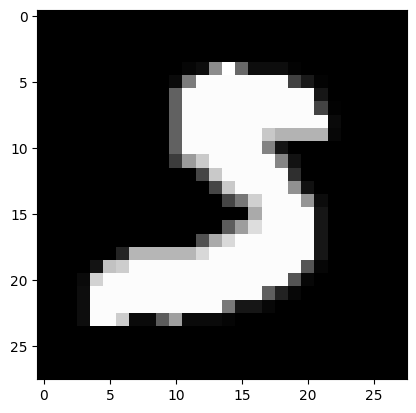

5


In [67]:
show_image(41138, dataset='train')
print(get_item(41138, dataset='train')[1])

In [63]:
def remove_element_from_dataset(dataset, remove_index):
    # Get the list of all indices except the one to be removed
    indices = list(range(len(dataset)))
    indices.pop(remove_index)

    # Create a new dataset as a subset using the remaining indices
    new_dataset = Subset(dataset, indices)

    return new_dataset

def leave_one_out_retrain(z_test, z_test_label, old_model, top_influential=top_influential_dict):
  loss_fn = nn.CrossEntropyLoss()
  # compute old test loss
  old_model.eval()
  old_loss = loss_fn(old_model(z_test), torch.tensor([z_test_label], dtype=torch.long))
  print("Old test loss: ", old_loss.item())

  change_in_test_loss = []

  count = 0
  for idx, val in top_influential.items():
    new_train_dataset = remove_element_from_dataset(train_data, remove_index=idx)
    new_train_loader = DataLoader(dataset=new_train_dataset, batch_size=1400, shuffle=False)

    new_model = LRModel()
    new_model.load_state_dict(torch.load('initial_model_weights.pth', weights_only=True))
    count += 1
    print("Retraining model #", count, " (idx=", idx, ")")

    train_model(new_model, new_train_loader, val_loader)
    new_loss = loss_fn(new_model(z_test), torch.tensor([z_test_label], dtype=torch.long))
    change_in_test_loss.append(new_loss - old_loss)
    print()
    print("Change in test loss: ", change_in_test_loss[-1].item())
    print()

  return change_in_test_loss

In [64]:
change_in_test_loss = leave_one_out_retrain(z_test, z_test_label, model)
print(change_in_test_loss)

Old test loss:  1.165305495262146
Retraining model # 1  (idx= 17788 )
Epoch 1, Loss: 1.3645132511854172
Validation Accuracy: 89.56%
Epoch 2, Loss: 0.6443393126130104
Validation Accuracy: 91.06%
Epoch 3, Loss: 0.4200751677155495
Validation Accuracy: 91.78%

Change in test loss:  0.010448217391967773

Retraining model # 2  (idx= 27827 )
Epoch 1, Loss: 1.3652991756796837
Validation Accuracy: 89.56%
Epoch 2, Loss: 0.6454876095056534
Validation Accuracy: 91.06%
Epoch 3, Loss: 0.4205560557544231
Validation Accuracy: 91.8%

Change in test loss:  0.016147375106811523

Retraining model # 3  (idx= 23464 )
Epoch 1, Loss: 1.3649997591972352
Validation Accuracy: 89.54%
Epoch 2, Loss: 0.6455323293805122
Validation Accuracy: 91.08%
Epoch 3, Loss: 0.42057744041085243
Validation Accuracy: 91.74%

Change in test loss:  -0.0035605430603027344

Retraining model # 4  (idx= 27874 )
Epoch 1, Loss: 1.3653376758098603
Validation Accuracy: 89.56%
Epoch 2, Loss: 0.6457755640149117
Validation Accuracy: 91.06%
Epo

Text(0, 0.5, 'Predicted diff in loss')

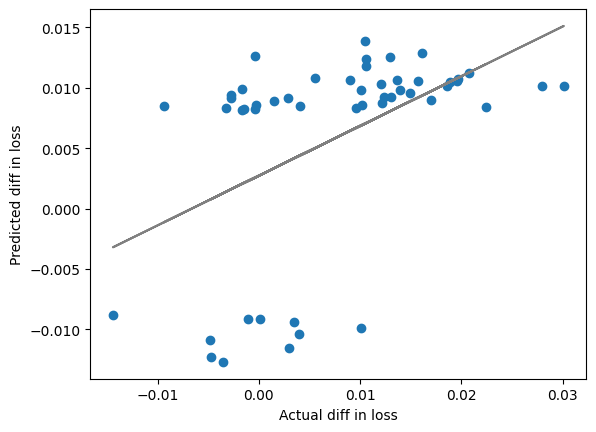

In [65]:
# plot scatter plot between actual diff in loss and predicted diff in loss
actual_diff_in_loss = [x.item() for x in change_in_test_loss]
predicted_diff_in_loss = [(-1/len(train_data))* x for x in top_influential_dict.values()]


plt.scatter(actual_diff_in_loss, predicted_diff_in_loss)

# plot a line of best fit
m, b = np.polyfit(actual_diff_in_loss, predicted_diff_in_loss, 1)
plt.plot(actual_diff_in_loss, m*np.array(actual_diff_in_loss) + b, color='gray')
plt.xlabel("Actual diff in loss")
plt.ylabel("Predicted diff in loss")